In [43]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading

import multiprocessing
##############


In [44]:
N = 4
dev_vqe = qml.device("default.mixed", wires = N)
J = 1
l_steps = 20
shift_invariance = 0

lams = np.linspace(0,2*J,l_steps)

In [45]:
###################
## VQE FUNCTIONS ##
###################

def qml_build_H(N, lam, J):
    '''
    Set up Hamiltonian: 
            H = lam*Σsigma^i_z - J*Σsigma^i_x*sigma^{i+1}_ 
    '''
    # Interaction of spins with magnetic field
    H = lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + J*(-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
    
    return H

def vqe_circuit_block_1(N, param, shift_invariance = 0, index = 0, p_noise = 0):
    '''
    RX + RY + CNOTS
    
    shift_invariance = 0: Each wire permorms independent rotations.
    shift_invariance = 1: Same rotation for odd and even wires,
                         expect for the first and last that have unique
                         rotation.
    shift_invariance = 2: Same rotation for each wire
    '''
    if shift_invariance == 0: # Independent rotations
        # Apply RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + spin],     wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            qml.RX(param[index + N + spin], wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
        return index + 2*N
        
    elif shift_invariance == 1: # RX and RY rotations
        # Apply RX + RY for first wire
        qml.RY(param[index + 0], wires = 0)
        qml.PhaseFlip(p_noise, wires = 0)
        qml.BitFlip(p_noise, wires = 0)
        qml.RX(param[index + 1], wires = 0)
        qml.PhaseFlip(p_noise, wires = 0)
        qml.BitFlip(p_noise, wires = 0)
        
        # Apply RX + RY for last wire
        qml.RY(param[index + 2], wires = N - 1)
        qml.PhaseFlip(p_noise, wires = N - 1)
        qml.BitFlip(p_noise, wires = N - 1)
        qml.RX(param[index + 3], wires = N - 1)
        qml.PhaseFlip(p_noise, wires = N - 1)
        qml.BitFlip(p_noise, wires = N - 1)

        # Apply RX + RY for even and odd wires
        for spin in range(1,N-1,2):
            qml.RY(param[index + 4], wires = spin)
            qml.RY(param[index + 5], wires = spin+1)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            qml.PhaseFlip(p_noise, wires = spin+1)
            qml.BitFlip(p_noise, wires = spin+1)
            qml.RX(param[index + 6], wires = spin)
            qml.RX(param[index + 7], wires = spin+1)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            qml.PhaseFlip(p_noise, wires = spin+1)
            qml.BitFlip(p_noise, wires = spin+1)
        
        return index + 8
    
    elif shift_invariance == 2:
        # Apply same RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + 0], wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            qml.RX(param[index + 1], wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            
        return index + 2
    
    else:
        raise ValueError('Invalid shift_invariance input value')
        
def vqe_circuit_block_2(N, param, shift_invariance = 0, index = 0, p_noise = 0):
    '''
    RY
    
    shift_invariance = 0: Each wire permorms independent rotations.
    shift_invariance = 1: Same rotation for odd and even wires,
                         expect for the first and last that have unique
                         rotation.
    shift_invariance = 2: Same rotation for each wire
    '''
    if shift_invariance == 0: # Independent rotations
        # Apply RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + spin],   wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            
    elif shift_invariance == 1: # RX and RY rotations
        # Apply RY for first wire
        qml.RY(param[index + 0], wires = 0)
        qml.PhaseFlip(p_noise, wires = 0)
        qml.BitFlip(p_noise, wires = 0)

        # Apply RY for last wire
        qml.RY(param[index + 1], wires = N - 1)
        qml.PhaseFlip(p_noise, wires = N - 1)
        qml.BitFlip(p_noise, wires = N - 1)

        # Apply RY for even and odd wires
        for spin in range(1,N-1,2):
            qml.RY(param[index + 2], wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
            qml.RY(param[index + 3], wires = spin+1)
            qml.PhaseFlip(p_noise, wires = spin+1)
            qml.BitFlip(p_noise, wires = spin+1)
        
    elif shift_invariance == 2:
        # Apply same RX and RY to each wire:
        for spin in range(N):
            qml.RY(param[index + 0], wires = spin)
            qml.PhaseFlip(p_noise, wires = spin)
            qml.BitFlip(p_noise, wires = spin)
         
    else:
        raise ValueError('Invalid shift_invariance input value')

def vqe_circuit_entanglement(N, p_noise_ent = 0):
    # Apply entanglement to the neighbouring spins
    for spin in range(0,N-1):
        qml.CNOT(wires = [spin, spin+1])
        qml.PhaseFlip(p_noise_ent, wires = spin+1)
        qml.BitFlip(p_noise_ent, wires = spin+1)
          
def vqe_circuit(N, params, shift_invariance = 0, p_noise = 0, p_noise_ent = 0):
    index = vqe_circuit_block_1(N, params, shift_invariance, p_noise = p_noise)
    vqe_circuit_entanglement(N, p_noise_ent)
    qml.Barrier()
    index = vqe_circuit_block_1(N, params, shift_invariance, index, p_noise)
    vqe_circuit_entanglement(N, p_noise_ent)
    qml.Barrier()
    vqe_circuit_block_2(N, params, shift_invariance, index, p_noise)

@qml.qnode(dev_vqe)
def vqe_cost_fn(vqe_params, N, shift_invariance, H, p_noise = 0, p_noise_ent = 0):
    vqe_circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(H)



In [46]:
drawer = qml.draw(vqe_cost_fn)
print(drawer([0]*100, N, 0, H = qml_build_H(N, 0 ,0), p_noise = 0.005, p_noise_ent = 0.005))

0: ──RY(0.00)──PhaseFlip(0.01)──BitFlip(0.01)──RX(0.00)──PhaseFlip(0.01)──BitFlip(0.01)─╭C
1: ──RY(0.00)──PhaseFlip(0.01)──BitFlip(0.01)──RX(0.00)──PhaseFlip(0.01)──BitFlip(0.01)─╰X
2: ──RY(0.00)──PhaseFlip(0.01)──BitFlip(0.01)──RX(0.00)──PhaseFlip(0.01)──BitFlip(0.01)───
3: ──RY(0.00)──PhaseFlip(0.01)──BitFlip(0.01)──RX(0.00)──PhaseFlip(0.01)──BitFlip(0.01)───

────────────────────────────────────────────────────────────────────────────────────────
───PhaseFlip(0.01)──BitFlip(0.01)─╭C────────────────────────────────────────────────────
──────────────────────────────────╰X──PhaseFlip(0.01)──BitFlip(0.01)─╭C─────────────────
─────────────────────────────────────────────────────────────────────╰X──PhaseFlip(0.01)

──────────────────||──RY(0.00)──PhaseFlip(0.01)──BitFlip(0.01)──RX(0.00)──PhaseFlip(0.01)
──────────────────||──RY(0.00)──PhaseFlip(0.01)──BitFlip(0.01)──RX(0.00)──PhaseFlip(0.01)
──────────────────||──RY(0.00)──PhaseFlip(0.01)──BitFlip(0.01)──RX(0.00)──PhaseFlip(0.01)
───BitFl

In [47]:
# Since we are parallelizing the VQE algorithm we cannot recycle the previous parameter for the next lambda
if shift_invariance == 0:
    n_params = 5*N
elif shift_invariance == 1:
    n_params = 20
elif shift_invariance == 2:
    n_params = 5

    
# Prepare initial parameters randomly for each datapoint/state
params0 = []
for _ in lams:
    param0 = np.random.rand(n_params)
    
    params0.append(param0)

In [48]:
def vqe_update_params_new(idx, params, N, shift_invariance, opts, Hs, p_noise, p_noise_ent):
    '''
    Update function to be called inside the training function
    idx              = index to update: idx in range(len(lambdas))
    N                = number of wires/spin
    shift_invariance = type of circuit
    opts             = array of optimizers
    Hs               = array of Hamiltonians
    p_noise          = noise after R-gates
    p_noise_ent      = noise after entanglements
    '''
    param = params[idx]
    H = Hs[idx]
    opt = opts[idx]

    cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)
    param_next, energy = opt.step_and_cost(cost_fn, param)

    return param_next, opt, (energy - np.min(qml.eigvals(H)) )**2

def train_vqe_ising(step_size, lams, n_epochs, N, J, params, shift_invariance = 0, p_noise = 0, p_noise_ent = 0, circuit = False, plots = False):
    
    # define the wrapper update function to be called inside a multiprocessing map 
    # as a global variable to avoid the pickle error with the Jupyter Kernel
    global wrapped_update
    
    '''
    n_epochs     = # epochs for the other lambdas
    lams         = Array of intensities of magnetic field
    N            = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size    = {0} (Step size of the optimizer)'.format(step_size))
    print('n_epochs     = {0} (# epochs for the other GSs'.format(n_epochs))
    print('N            = {0} (Number of spins of the system)'.format(N))
        
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        drawer = qml.draw(vqe_cost_fn)
        print(drawer([0]*100, N, shift_invariance, H = qml_build_H(N, 0 ,0)))
    
    # For each lamda create optimizer and H
    Hs   = []
    opts = []
    energy_err  = [0]*(len(lams))
    MSE = []
    
    for lam in lams:
        Hs.append(qml_build_H(N, float(lam), float(J) ))
        opts.append(qml.AdamOptimizer(stepsize=step_size))
    
    progress = tqdm(range(n_epochs))
    
    for epoch in progress:
        def wrapped_update(idx):
            return vqe_update_params_new(idx, params, N, shift_invariance, opts, Hs, p_noise, p_noise_ent)
        
        p = multiprocessing.Pool()
        with p: rdata = p.map(wrapped_update, np.arange(len(lams)) )
        
        for l in range(len(lams)):
            params[l], opts[l],energy_err[l] = rdata[l]
        
        MSE.append(np.mean(energy_err))
        
        progress.set_description('Cost: {0}'.format(MSE[-1]) )
                      
    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(12,14))
        vqe_e  = []
        true_e = []
        for i, lam in enumerate(lams):
            cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, Hs[i], p_noise, p_noise_ent)
            true_e.append(np.min(qml.eigvals(Hs[i])) )
            vqe_e.append(cost_fn(params[i]) )
                          
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()
        
        ax[1].plot(range(n_epochs), MSE, '.', color='orange', ms = 7 )
        ax[1].plot(range(n_epochs), MSE, color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        ax[2].legend()
        
        plt.tight_layout()

***Parameters:***

step_size    = 0.5 (Step size of the optimizer)
n_epochs     = 50 (# epochs for the other GSs
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──PhaseFlip(0.00)──BitFlip(0.00)──RX(0.00)──PhaseFlip(0.00)──BitFlip(0.00)─╭C
1: ──RY(0.00)──PhaseFlip(0.00)──BitFlip(0.00)──RX(0.00)──PhaseFlip(0.00)──BitFlip(0.00)─╰X
2: ──RY(0.00)──PhaseFlip(0.00)──BitFlip(0.00)──RX(0.00)──PhaseFlip(0.00)──BitFlip(0.00)───
3: ──RY(0.00)──PhaseFlip(0.00)──BitFlip(0.00)──RX(0.00)──PhaseFlip(0.00)──BitFlip(0.00)───

────────────────────────────────────────────────────────────────────────────────────────
───PhaseFlip(0.00)──BitFlip(0.00)─╭C────────────────────────────────────────────────────
──────────────────────────────────╰X──PhaseFlip(0.00)──BitFlip(0.00)─╭C─────────────────
─────────────────────────────────────────────────────────────────────╰X──PhaseFlip(0.00)

──────────────────||──RY(0.00)──PhaseFlip(0.00)──BitFlip(0.00)──RX(0.00)──PhaseFlip(0.00)
──────────────────||──RY(0.00)──PhaseFlip(0.00)──BitFlip(0.00)──RX(0.00)──PhaseFlip(0.00)
──────────────────||──RY(0.00)──PhaseFlip(0.00)──BitFlip(0.00)──RX(0.00)──PhaseFlip(0.00)
───BitFl

  0%|          | 0/50 [00:00<?, ?it/s]

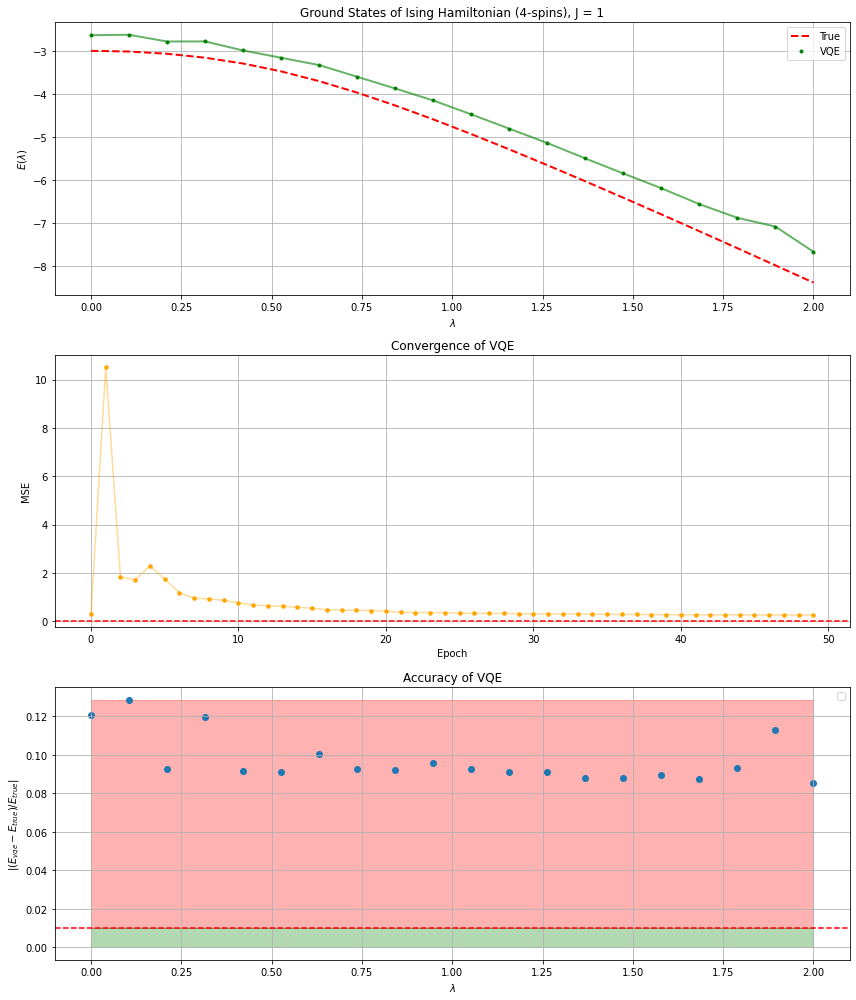

In [50]:
train_vqe_ising(0.5, lams, 50, N, J, params0, circuit = True, plots = True, p_noise = .005, p_noise_ent = .005)